## Trying out a linear model: 

Authors: Jacob Lindberg and Alexander Matsson

Inspired by: Alexandru Papiu ([@apapiu](https://twitter.com/apapiu), [GitHub](https://github.com/apapiu))
 
If you use parts of this notebook in your own scripts, please give some sort of credit (for example link back to this). Thanks!


There have been a few [great](https://www.kaggle.com/comartel/house-prices-advanced-regression-techniques/house-price-xgboost-starter/run/348739)  [scripts](https://www.kaggle.com/zoupet/house-prices-advanced-regression-techniques/xgboost-10-kfolds-with-scikit-learn/run/357561) on [xgboost](https://www.kaggle.com/tadepalli/house-prices-advanced-regression-techniques/xgboost-with-n-trees-autostop-0-12638/run/353049) already so I'd figured I'd try something simpler: a regularized linear regression model. Surprisingly it does really well with very little feature engineering. The key point is to to log_transform the numeric variables since most of them are skewed.

# About 

## Task 

1. Build a model for predicting as best as possible the amount of money (in initial currency) pledged by a project at the deadline date. Explain your choice of data preprocessing and algorithm.
2. Describe and justify the score used to evaluate the model
3. Explain some possible shortcomings in your model and what you would do to improve it

The submission should contain:

1. The code written for solving the task
2. A readme file with instructions on how to run the code
3. A text document with written answers to the three questions in the


## Variables: 

* ID - Id of the project
* name - Title of the project
* category - Kickstarter sub category
* main_category - Kickstarter main category
* currency - Initial currency of the project
* deadline - Project deadline
* goal - Project goal
* launched - Project launch date
* pledged - Amount pledged in initial currency
* state - Project current state
* backers - Number of backers
* country - Country of project creator
* usd_pledged - conversion of pledged amount in USD

qq is `goal` in the initial currency? We assume so. From running the code below that is the only reasonable conclusion. 
`df.loc[df.currency != 'USD', ['currency', 'goal', 'pledged', 'usd_pledged']].head(15)`

currency and country are correlated to use only one. 

qq it is currently not clear to us what should be predicted. usually you get a train.csv and test.csv. if you don't get that, it is specified that rows 1:k are training set and k:end are the test set. maybe we do not have a test set here and have to create one ourselves. 

In [1]:
# basics 
import pandas as pd
import numpy as np

# stats 
from scipy.stats import skew
from scipy.stats.stats import pearsonr

# sklearn 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer

# plots 
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

### Import data 

In [2]:
person = 'Jacob'

if person == 'Jacob':
    df = pd.read_csv("../../datasets/kickstarter/kickstarter_data.tsv", sep='\t')
else:
    df = pd.read_csv("../../datasets/kickstarter/kickstarter_data.tsv", sep='\t')

# Inspect

In [3]:
df.shape

(2149, 23)

In [4]:
df.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd_pledged', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19',
       'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22'],
      dtype='object')

In [5]:
df.head(2)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0,failed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 4:43:57,2421,failed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
n = df.shape[0]

In [7]:
df.loc[0:2, :].T

,0,1,2
ID,1000002330,1000003930,1000004038
name,The Songs of Adelaide & Abullah,Greeting From Earth: ZGAC Arts Capsule For ET,Where is Hank?
category,Poetry,Narrative Film,Narrative Film
main_category,Publishing,Film & Video,Film & Video
currency,GBP,USD,USD
deadline,2015-10-09,2017-11-01,2013-02-26
goal,1000,30000,45000
launched,2015-08-11 12:12:28,2017-09-02 4:43:57,2013-01-12 0:20:50
pledged,0,2421,220
state,failed,failed,failed


# Clean

## rename and drop 

In [8]:
# rename for quicker typing
df.columns = df.columns.str.replace('Unnamed: ', 'v')

In [9]:
# ID gives no information so drop it 
assert df.ID.nunique() == df.shape[0] # not needed 
id_list = df.ID # needed for submission
del df['ID']

## put into buckets

In [10]:
cols_date = ['deadline', 'launched']

In [11]:
cols_num = ['backers', 'goal', 'pledged', 'usd_pledged']

In [12]:
# the rest are categorical - except 'name'.
cols_cat = set(df.columns) - set(['name']) - set(cols_date) - set(cols_num)
cols_cat = list(cols_cat)

## correct dtype

In [13]:
# as type category
df[cols_cat] = df[cols_cat].apply(lambda x: x.astype('category'))

In [14]:
# to numeric
for col in cols_num:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [15]:
assert (df[cols_cat].dtypes != 'category').values.sum() == 0
assert (df[cols_num].dtypes != 'float64').values.sum() == 0

## Convert to usd

In [16]:
df.loc[df.currency != 'USD', ['currency', 'goal', 'pledged', 'usd_pledged']].head(10)

,currency,goal,pledged,usd_pledged
0,GBP,1000.0,0.00,0.000000
10,CAD,2500.0,0.00,0.000000
14,GBP,5000.0,94175.00,121857.329600
21,AUD,2500.0,1.00,0.810438
23,NOK,500.0,48.00,6.292524
26,GBP,12000.0,0.00,0.000000
27,CAD,17757.0,48905.00,42174.025530
28,GBP,100.0,112.38,160.604805
30,GBP,3500.0,21.00,31.086702
32,AUD,2000.0,2000.00,1427.347987


In [17]:
df['usd_goal'] = df.goal / (df.pledged / df.usd_pledged)

In [18]:
df.loc[df.currency != 'USD', ['goal', 'usd_goal', 'usd_pledged']].head()

,goal,usd_goal,usd_pledged
0,1000.0,NaN,0.000000
10,2500.0,NaN,0.000000
14,5000.0,6469.728144,121857.329600
21,2500.0,2026.096118,0.810438
23,500.0,65.547122,6.292524


This will not work. I have to load a new table with fx rates if this is to work properly. And then merge it in and create a usd_goal column. For 12% of the rows pledged = 0 so I cannot convert `goal` for those, unless I load in a new table. And it might worsen the predictions if we deal with different fx rates because y will vary a lot. Thus, in the beta version of this notebook we throw out everything that is not USD. 

In [19]:
df = df.loc[df.currency == 'USD']

# EDA 

## Categorical columns

In [20]:
cols_cat

['v16',
 'v13',
 'v19',
 'state',
 'v17',
 'currency',
 'country',
 'v14',
 'v22',
 'v21',
 'v20',
 'v15',
 'v18',
 'main_category',
 'category']

In [21]:
cols_1 = ['main_category', 'state', 'currency', 'category', 'country']
cols_v = list(set(cols_cat) - set(cols_1))

In [22]:
df[cols_1].nunique()

main_category     15
state              7
currency           1
category         127
country           70
dtype: int64

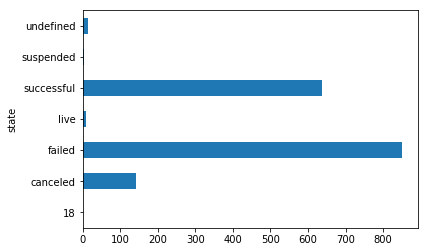

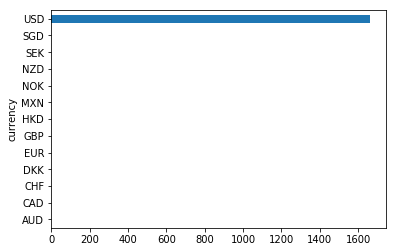

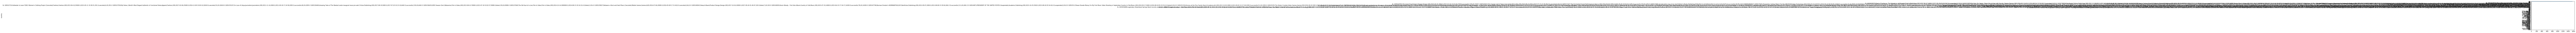

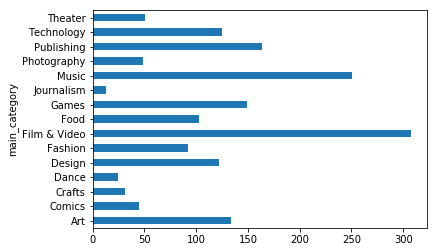

In [23]:
cols_2 = list(set(cols_1) - set(["category"]))

for col in cols_2:
    df.groupby(by = col)[col].count().plot.barh()
    plt.show()

qq some have been canceled, even though they raised enough. what should we do with those? maybe these are exceptions and set status == successful?

Conclusion: Firstly use only `main_category` and not `category`

Maybe need to train data on state = failed or successful, not on the others?? 

In [24]:
# find out which are categorical
n / df.nunique() # higher value => higher pr the col is categorical 

name                1.293020
category           16.921260
main_category     143.266667
currency         2149.000000
deadline            1.793823
goal                8.561753
launched            1.293020
pledged             1.987974
state             307.000000
backers             6.843949
country            30.700000
usd_pledged         2.131944
v13               195.363636
v14               268.625000
v15               214.900000
v16               153.500000
v17               153.500000
v18               153.500000
v19               238.777778
v20               179.083333
v21               268.625000
v22               165.307692
usd_goal            9.551111
dtype: float64

We know country and category are categorical, they have values 17 and 15. Hence all unnamed are categorical. We know goal is numerical and it has value 7.6 (because people chose round nice numbers). 

In [26]:
df.loc[1, :]

name             Greeting From Earth: ZGAC Arts Capsule For ET
category                                        Narrative Film
main_category                                     Film & Video
currency                                                   USD
deadline                                            2017-11-01
goal                                                     30000
launched                                    2017-09-02 4:43:57
pledged                                                   2421
state                                                   failed
backers                                                     15
country                                                     US
usd_pledged                                               2421
v13                                                        NaN
v14                                                        NaN
v15                                                        NaN
v16                                                    

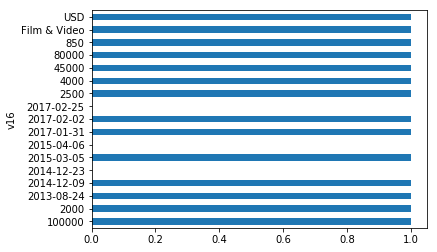

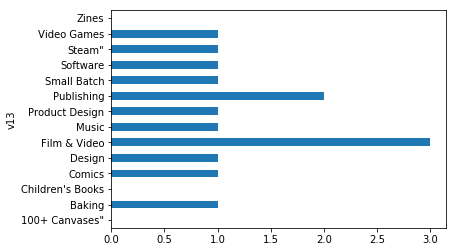

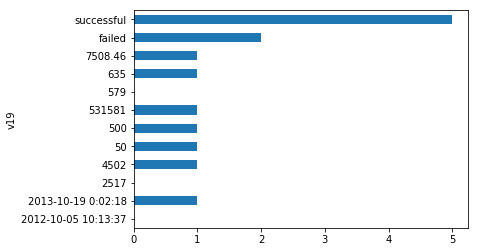

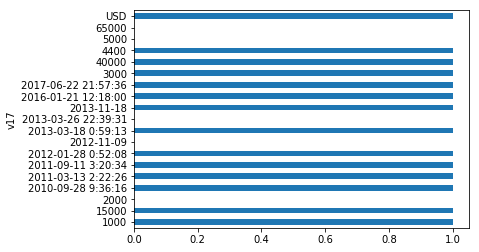

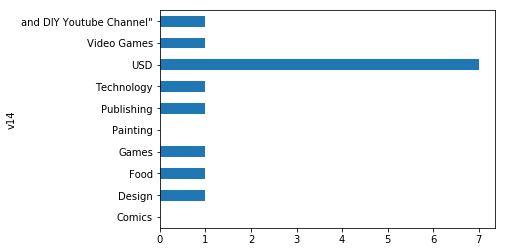

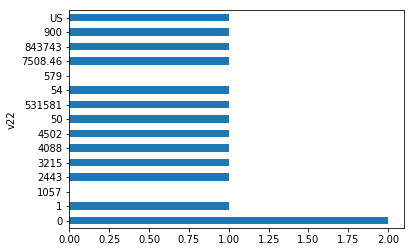

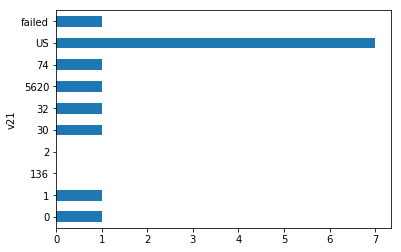

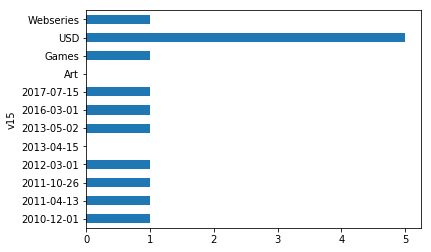

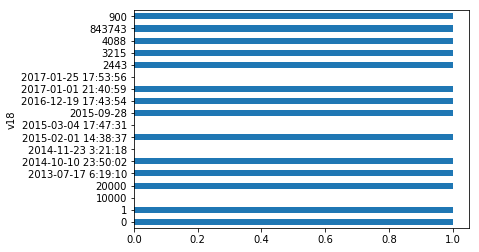

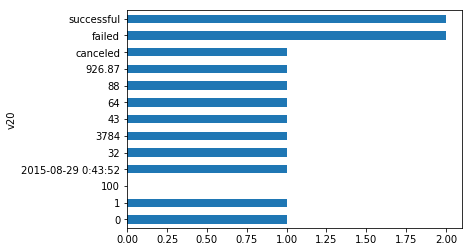

In [27]:
# all "unknown" cols are messy except v13
for col in cols_v:
    df.groupby(by = col)[col].count().plot.barh()
    plt.show()

In [28]:
# but v13 has high NA count
df.isnull().sum() / n

name             0.000000
category         0.000000
main_category    0.000000
currency         0.000000
deadline         0.000000
goal             0.000000
launched         0.000000
pledged          0.000931
state            0.000931
backers          0.010237
country          0.010237
usd_pledged      0.045137
v13              0.766868
v14              0.766868
v15              0.766868
v16              0.766868
v17              0.766868
v18              0.766868
v19              0.766868
v20              0.766868
v21              0.766868
v22              0.766868
usd_goal         0.140065
dtype: float64

In [30]:
df.drop(cols_v, axis=1, inplace=True)

## Numerical columns

Correlation with y

Histogram and boxplots

In [31]:
df.select_dtypes(include=['float64']).columns

Index(['goal', 'pledged', 'backers', 'usd_pledged', 'usd_goal'], dtype='object')

In [32]:
# remove rows where col is NA
# df = df[pd.notnull(df['backers'])]

In [33]:
# NA fraction 
df[cols_num].isnull().sum() / n

backers        0.010237
goal           0.000000
pledged        0.000931
usd_pledged    0.045137
dtype: float64

In [34]:
cols_3 = ['usd_pledged', 'goal']

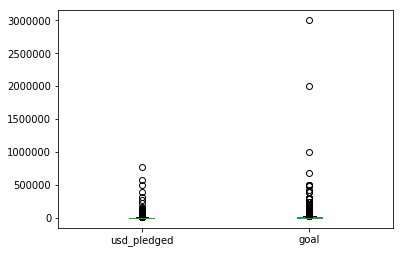

In [35]:
df[cols_3].plot(kind='box')

In [36]:
q = 0.99
df = df.loc[df.usd_pledged < df.usd_pledged.quantile(q)]
df = df.loc[df.goal < df.goal.quantile(q)]

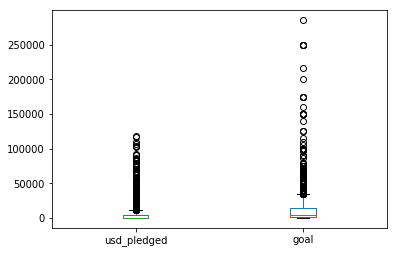

In [37]:
df[cols_3].plot(kind='box')

regression will not work with huge outliers, that's why we dropped those rows. qq make sure they were not in the test set!

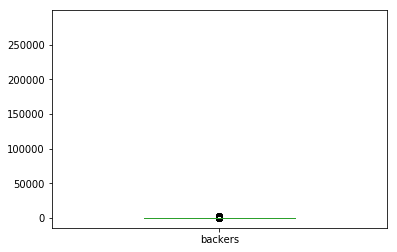

In [38]:
df[cols_num].plot.box()
df['backers'].plot.box()

---

In [39]:
df['madeit'] = df.pledged > df.goal
print(df.loc[df.state == 'canceled', 'madeit'].sum())
del df['madeit']

1


In [40]:
# recode state
df["state"].replace({"18":"successful", 
                     "undefined":"failed", 
                     "suspended":"failed"}, 
                    inplace=True)

---

# Model

## Select X

In [41]:
df.columns

Index(['name', 'category', 'main_category', 'currency', 'deadline', 'goal',
       'launched', 'pledged', 'state', 'backers', 'country', 'usd_pledged',
       'usd_goal'],
      dtype='object')

In [42]:
cols_x = ['backers']

# NA

In [43]:
df2 = df.dropna(subset=cols_x)

In [44]:
X = df2[cols_x]
y = df2.pledged # maybe =usd_pledged later on... 

## train test split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=9)

In [46]:
X_train.shape, X_test.shape

((1149, 1), (383, 1))

# Stolen code below

### Data preprocessing: 

We're not going to do anything fancy here: 
 
- First I'll transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal    
- Create Dummy variables for the categorical features    
- Replace the numeric missing values (NaN's) with the mean of their respective columns

In [ ]:
# plt.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price" : train["SalePrice"], 
                       "log(price + 1)" : np.log1p(train["SalePrice"])
                      })
prices.hist()

In [ ]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75].index
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [ ]:
cols_object = all_data.dtypes[all_data.dtypes == 'object'].index
all_data[cols_object].nunique().sort_values() #/ n * 100

In [ ]:
# too many unique and I dont think its imporatnt 
all_data.drop(['Exterior1st', 'Exterior2nd'], axis = 1, inplace = True)

In [ ]:
all_data = pd.get_dummies(all_data, dummy_na = True)

In [ ]:
all_data.shape

In [ ]:
all_data.isnull().sum().sort_values().tail(10)

In [ ]:
all_data.drop(['LotFrontage', 'GarageYrBlt'], inplace = True, axis = 1)

In [ ]:
#filling NA's with the mean of the column
all_data = all_data.fillna(all_data.mean())

In [ ]:
#creating matrices for sklearn:
X_trainset = all_data[:train.shape[0]]
X_testset = all_data[train.shape[0]:]
y = train.SalePrice

# split trainset into _train and _test
X_train, X_test, y_train, y_test = train_test_split(X_trainset, y)

In [ ]:
y_train.shape, y_test.shape

### Model 1 - from "regularized-linear-models"

Now we are going to use regularized linear regression models from the scikit learn module. I'm going to try both l_1(Lasso) and l_2(Ridge) regularization. I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning par

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [ ]:
model_ridge = Ridge()

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

In [ ]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

In [ ]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

Note the U-ish shaped curve above. When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha small) the model begins to overfit. A value of alpha = 10 is about right based on the plot above.

In [ ]:
cv_ridge.min()

So for the Ridge regression we get a rmsle of about 0.127

Let' try out the Lasso model. We will do a slightly different approach here and use the built in Lasso CV to figure out the best alpha for us. For some reason the alphas in Lasso CV are really the inverse or the alphas in Ridge.

In [ ]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)

In [ ]:
rmse_cv(model_lasso).mean()

Nice! The lasso performs even better so we'll just use this one to predict on the test set. Another neat thing about the Lasso is that it does feature selection for you - setting coefficients of features it deems unimportant to zero. Let's take a look at the coefficients:

In [ ]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [ ]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Good job Lasso.  One thing to note here however is that the features selected are not necessarily the "correct" ones - especially since there are a lot of collinear features in this dataset. One idea to try here is run Lasso a few times on boostrapped samples and see how stable the feature selection is.

We can also take a look directly at what the most important coefficients are:

In [ ]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

In [ ]:
# matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

The most important positive feature is `GrLivArea` -  the above ground area by area square feet. This definitely sense. Then a few other  location and quality features contributed positively. Some of the negative features make less sense and would be worth looking into more - it seems like they might come from unbalanced categorical variables.

 Also note that unlike the feature importance you'd get from a random forest these are _actual_ coefficients in your model - so you can say precisely why the predicted price is what it is. The only issue here is that we log_transformed both the target and the numeric features so the actual magnitudes are a bit hard to interpret. 

In [ ]:
#let's look at the residuals as well:
#matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

The residual plot looks pretty good.To wrap it up let's predict on the test set and submit on the leaderboard:

### Sumbit approach  1 

Many times it makes sense to take a weighted average of uncorrelated results - this usually imporoves the score although in this case it doesn't help that much.

In [ ]:
# preds = 0.7*lasso_preds + 0.3*xgb_preds

In [ ]:
solution = pd.DataFrame({"id":test_id, "SalePrice":preds["preds"]})
solution.to_csv("ridge_sol.csv", index = False)

### Model approach 2: elasticnet

from https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

In [48]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

In [49]:
# 4* ElasticNet
alpha_list = [0.00001, 0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6]
l1_list = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1]
elasticNet = ElasticNetCV(l1_ratio = l1_list, alphas = alpha_list, max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

Best l1_ratio : 0.1
Best alpha : 6.0


In [50]:
# we need not change our initial alpha values 
assert min(alpha_list) < alpha < max(alpha_list)

AssertionError: 

In [51]:
# Try again for more precision with l1_ratio centered around the best ratio above 
variation = [.85, .9, .95, 1, 1.05, 1.1, 1.15]
ratio_list = ratio * np.array(variation)
elasticNet = ElasticNetCV(l1_ratio = ratio_list, alphas = alpha_list, max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

Best l1_ratio : 0.085
Best alpha : 6.0


In [52]:
# "Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
# " and alpha centered around " + str(alpha))
alpha_list =  alpha * np.linspace(0.6, 1.4, 17)
elasticNet = ElasticNetCV(l1_ratio = ratio, alphas = alpha_list, max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

Best l1_ratio : 0.085
Best alpha : 8.4


In [53]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split

In [54]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [55]:
# Calculate RMSE
rmse1 = rmse_cv_train(elasticNet).mean()
print("ElasticNet RMSE on Training set :", rmse1)
# print("ElasticNet RMSE on Test set :", rmse_cv_test(elasticNet).mean())

ElasticNet RMSE on Training set : 8674.21342895


In [56]:
# predict 
y_train_ela = elasticNet.predict(X_train)
y_test_ela = elasticNet.predict(X_test)

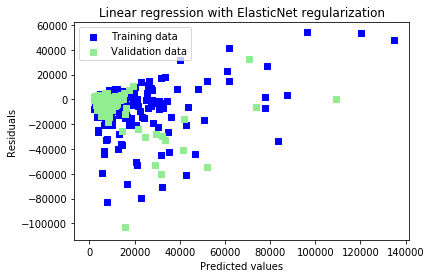

In [57]:
# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

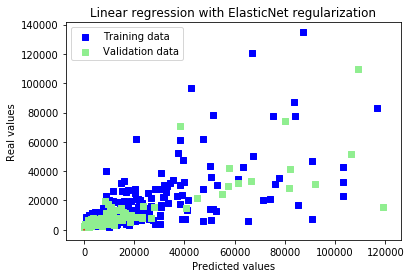

In [58]:
# Plot predictions
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

ElasticNet picked 1 features and eliminated 0 features


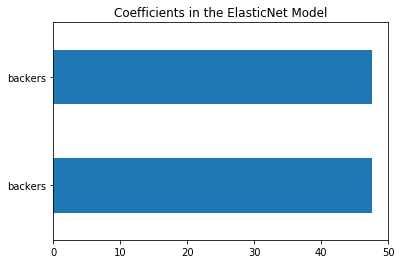

In [59]:
# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + 
      " features and eliminated " +  
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

In [ ]:
# submit 

pred_final = elasticNet.predict(X_test)

solution2 = pd.DataFrame({"id":test_id, "SalePrice":pred_final})
solution2.to_csv("elastic_sol.csv", index = False)